In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import *
import tensorflow as tf
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [29]:
# Load the dataset from a CSV file
df=pd.read_csv(r"Data_V1.csv")

In [30]:

# Initialize OrdinalEncoder to encode categorical variables
ord_enc = OrdinalEncoder()
# Use OrdinalEncoder to transform the 'Market_condition' column and store the encoded values
df["Market_condition"] = ord_enc.fit_transform(df[["Market_condition"]])
# Convert the 'Date' column values to Pandas Timestamp and then convert them to Unix timestamps
df['Date'] = pd.to_datetime(df['Date']).apply(lambda x: x.timestamp())
# Set the 'Date' column as the index of the DataFrame 'df'
df=df.set_index('Date')
# 'X' contains the dataset, which will be used for modeling (input features and target variable)
X = df

In [31]:
# Split the dataset 'X' into training and test sets
# random_state=0 ensures reproducibility, train_size=0.8 specifies the proportion of the dataset allocated to training
train_X, test_X = train_test_split(X, random_state=0, train_size = .8)
print(train_X.shape, test_X.shape)

(1207, 193) (302, 193)


In [11]:
# Assign the training dataset 'train_X' to 'train'
train = train_X
# Initialize an empty dictionary to store MinMaxScaler objects for each column
scalers={}
# Loop through each column in the training dataset
for i in train_X.columns:
    # Create a MinMaxScaler object that scales values to a range of (-1, 1)
    scaler = MinMaxScaler(feature_range=(-1,1))
    # Scale the values of the current column in the training dataset 'train'
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    # Reshape the scaled values to a one-dimensional array
    s_s=np.reshape(s_s,len(s_s))
    # Store the scaler object in the 'scalers' dictionary with a key prefixed by 'scaler_'
    scalers['scaler_'+ i] = scaler
    # Update the training dataset 'train' with the scaled values for the current column 'i'
    train[i]=s_s
# Assign the test dataset 'test_X' to 'test'
test = test_X
# Loop through each column in the training dataset again
for i in train_X.columns:
     # Retrieve the corresponding scaler object from the 'scalers' dictionary
    scaler = scalers['scaler_'+i]
    # Scale the values of the current column in the test dataset 'test'
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    # Reshape the scaled values to a one-dimensional array
    s_s=np.reshape(s_s,len(s_s))
    # Update the 'scalers' dictionary with the current scaler object
    scalers['scaler_'+i] = scaler
    # Update the test dataset 'test' with the scaled values for the current column 'i'
    test[i]=s_s

In [12]:

def split_series(series, n_past, n_future):
  # Initialize empty lists to store input (X) and output (y) sequences
  X, y = list(), list()
  # Iterate through the time series data
  for window_start in range(len(series)):
    # Define the start and end points for the past and future sequences
    past_end = window_start + n_past
    future_end = past_end + n_future
    # Check if the future end index is beyond the series length
    if future_end > len(series):
      break # If true, exit the loop
    # Slice the series to extract past and future sequences
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    # Append the sequences to the X and y lists
    X.append(past)
    y.append(future)
    # Convert the lists into NumPy arrays and return them as X and y
  return np.array(X), np.array(y)

In [13]:
# Data Sequencing for LSTM
n_past = 200    # Number of past time steps
n_future = 3    # Number of future time steps
n_features = 193# Number of input features

In [14]:
# Splitting the training data into input sequences (X_train) and output/target sequences (y_train)
# using a function 'split_series' defined previously, which generates input-output pairs of sequences.
X_train, y_train = split_series(train.values,n_past, n_future)
# Splitting the test data into input sequences (X_test) and output/target sequences (y_test)
# using the same function 'split_series' applied to the test dataset.
X_test, y_test = split_series(test.values,n_past, n_future)
# Reshaping the training input sequences (X_train) to match the expected input shape of the LSTM model.
# The shape of the input sequences is modified to include the number of features (n_features).
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))

In [15]:
# Reshape the training input data (X_train) to match the input shape required by the LSTM model.
# X_train.shape[0] represents the number of samples, X_train.shape[1] represents the number of time steps (past observations),
# and n_features represents the number of input features.
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
# Reshape the training target data (y_train) to match the output shape required by the LSTM model.
# y_train.shape[0] represents the number of samples, y_train.shape[1] represents the number of time steps (future observations),
# and n_features represents the number of output features (should match the number of input features).
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
# Reshape the testing input data (X_test) to match the input shape required by the LSTM model.
# Similar to the reshaping of the training input data (X_train).
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
# Reshape the testing target data (y_test) to match the output shape required by the LSTM model.
# Similar to the reshaping of the training target data (y_train).
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
# Model Building - E1D1 Architecture
# Define input shape for the encoder
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
# Create the first LSTM layer for encoding the input sequences
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
# Connect the encoder input to the first LSTM layer
encoder_outputs1 = encoder_l1(encoder_inputs)
# Capture the LSTM layer states (hidden and cell state)
encoder_states1 = encoder_outputs1[1:]  # Exclude the output sequence
# Repeat the output of the encoder to be fed into the decoder
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
# Define the first LSTM layer for the decoder with initial states from 
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
# Apply TimeDistributed Dense layer to produce output sequences
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
# Construct the model using encoder and decoder inputs/outputs
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
# Display the model summary showing its architecture
model_e1d1.summary()

In [ ]:
# Model Building - E2D2 Architecture 
# Define the input shape for the encoder as (n_past, n_features)
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
# Define the first LSTM layer of the encoder with 100 units, returning sequences and states
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
# Pass the encoder input to the first LSTM layer
encoder_outputs1 = encoder_l1(encoder_inputs)
# Extract the encoder states from the outputs (discard the sequences)
encoder_states1 = encoder_outputs1[1:]
# Define the second LSTM layer of the encoder with 100 units, returning states
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
# Pass the output sequences from the first LSTM layer to the second LSTM layer
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
# Extract the encoder states from the second LSTM layer
encoder_states2 = encoder_outputs2[1:]
# Define the input for the decoder by repeating the output of the second LSTM layer n_future times
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
# Define the first LSTM layer of the decoder with 100 units, returning sequences
# Use the states from the first encoder LSTM layer as initial states
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
# Define the second LSTM layer of the decoder with 100 units, returning sequences
# Use the states from the second encoder LSTM layer as initial states
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
# Apply a TimeDistributed layer with a Dense layer having n_features units to the decoder output
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
# Create the E2D2 model using the defined encoder and decoder architecture
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
# Display the summary of the E2D2 model architecture
model_e2d2.summary()

In [ ]:
# Learning rate scheduler for reducing learning rate during training epochs
# Exponential decay function: lr = 1e-3 * 0.90 ^ x, where x is the epoch number
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
# Compiling the model for training (E1D1 architecture)
# Using Adam optimizer, Huber loss function, and accuracy as a metric for evaluation
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber(),metrics=['accuracy'])
# Training the E1D1 model using fit method
# X_train: Input training sequences, y_train: Target sequences
# Validation data: X_test (validation input sequences), y_test (validation target sequences)
# 25 epochs, batch size of 32, verbose output during training, using reduce_lr callback for learning rate scheduling
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])


In [ ]:
# Compile the E2D2 model with specified optimizer, loss function, and metrics
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber(),metrics=['accuracy']) 
# Train the E2D2 model using the training data (X_train, y_train) for 25 epochs
# Perform validation on the test data (X_test, y_test)
# Use a batch size of 32, display progress during training, and apply a learning rate decay callback (reduce_lr)
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

In [20]:
# Model Evaluation
# Making predictions using model_e1d1 on the test data X_test
pred_e1d1=model_e1d1.predict(X_test)
# Making predictions using model_e2d2 on the test data X_test
pred_e2d2=model_e2d2.predict(X_test)

4/4 [==============================] - 2s 76ms/step


In [21]:
# Inverse Transformations
# Iterate through columns in the training dataset
for index,i in enumerate(train_X.columns):
    # Retrieve the scaler associated with the current column 'i'
    scaler = scalers['scaler_'+i]
    # Inverse transform predictions made by model_e1d1 to original scale for the current column
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    # Inverse transform predictions made by model_e2d2 to original scale for the current column
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    # Inverse transform y_train (training target values) to original scale for the current column
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    # Inverse transform y_test (test target values) to original scale for the current column
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

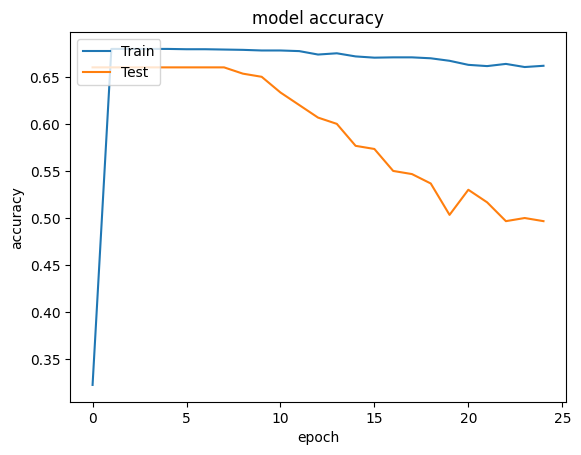

In [22]:
# summarize history for accuracy
plt.plot(history_e1d1.history['accuracy'])
plt.plot(history_e1d1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

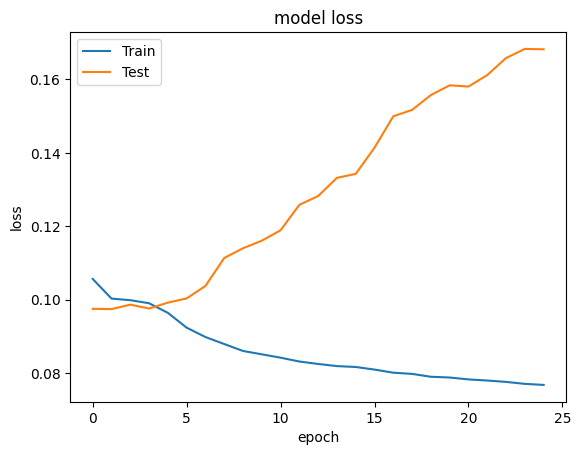

In [23]:
# Plotting the training and validation loss over epochs for model_e1d1
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])
plt.show()

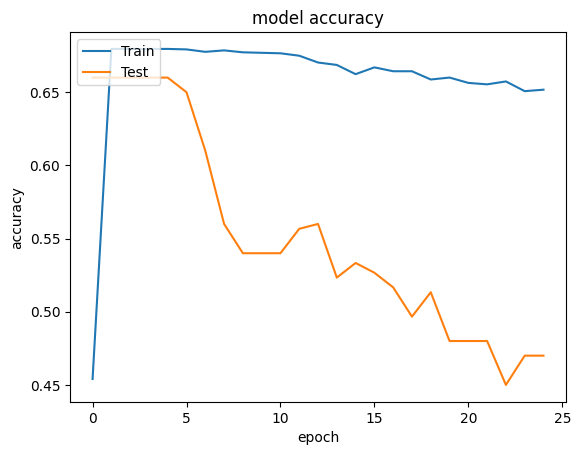

In [24]:
# summarize history for accuracy
plt.plot(history_e2d2.history['accuracy'])
plt.plot(history_e2d2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

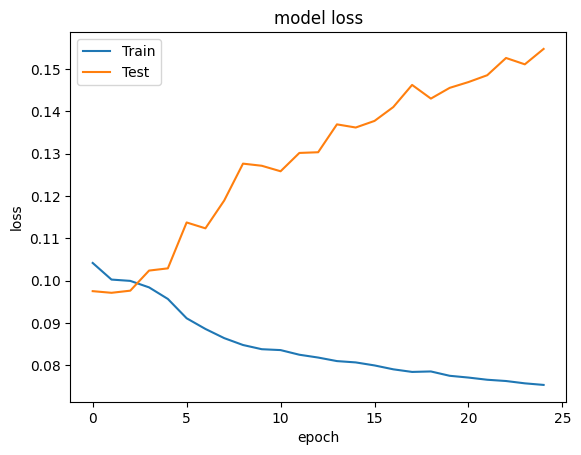

In [25]:
# Plotting the training and validation loss over epochs for model_e2d2
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
# Performance Evaluation
# Iterate through columns in the 'train_X' dataset
for index,i in enumerate(train_X.columns):
  print(i)
  # Iterate through days 1 to 3
  for j in range(1,4):
    # Print the current day
    print("Day ",j,":")
    # Calculate and print the Mean Absolute Error (MAE) for model_e1d1 and model_e2d2
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

In [ ]:
# Print model accuracy for E1D1
print("E1D1 Model Accuracy:")
# Loop through each epoch's accuracy for E1D1 model and print train and validation accuracy
for epoch in range(len(history_e1d1.history['accuracy'])):
    # Prints epoch number along with corresponding train and validation accuracy for E1D1 model
    print(f"Epoch {epoch + 1} - Train Accuracy: {history_e1d1.history['accuracy'][epoch]}, Validation Accuracy: {history_e1d1.history['val_accuracy'][epoch]}")

# Print model accuracy for E2D2
print("\nE2D2 Model Accuracy:")
# Loop through each epoch's accuracy for E2D2 model and print train and validation accuracy
for epoch in range(len(history_e2d2.history['accuracy'])):
    # Prints epoch number along with corresponding train and validation accuracy for E2D2 model
    print(f"Epoch {epoch + 1} - Train Accuracy: {history_e2d2.history['accuracy'][epoch]}, Validation Accuracy: {history_e2d2.history['val_accuracy'][epoch]}")

